<h2>Research Question:</h2>
<p style="font-size: 16px">
Tentative  Research Questions:
"Based on city-wide income levels in New York City, how do they correlate with the prevalence of felony and non-felony crimes? Using this correlation, can we construct a predictive model, incorporating economic data (such as police spending and income) and criminal data (like types of crimes (non-felony vs felony), that can be applied to forecast potential criminal behaviors in other cities?"<p>

<p style="font-size: 16px">
How do city-wide income levels in New York City historically relate to overall crime rates?
Is there a discernible pattern between felony and non-felony crimes in relation to city-wide income disparities?
<p>

<h1>Data Description</h1>

<h3>Data Description for NYPD SPENDING DATA:
</h3>


<strong>What are the observations (rows) and the attributes (columns)? </strong>

Observations (Rows): Each row in the dataset represents the NYPD's total spending for a specific fiscal year.
Attributes (Columns): There are two columns in the dataset - 'Fiscal Year' and 'Total Spending'. 'Fiscal Year' indicates the year for which the spending is recorded, and 'Total Spending' represents the amount spent by the NYPD in that year.

<strong>Why was this dataset created?</strong>

The dataset was likely created to provide transparency and insight into the NYPD's financial allocations over time. It serves as a tool for accountability, budget planning, and policy analysis regarding police funding in New York City.

<strong>Who funded the creation of the dataset?</strong>

The dataset is likely funded and maintained by the New York City government, specifically through departments responsible for budget and financial oversight, such as the New York City Independent Budget Office.

<strong>What processes might have influenced what data was observed and recorded and what was not?</strong>

The data recording process would be influenced by financial recording standards, budgetary practices, and fiscal policies of the New York City government. Factors like changes in budget allocation policies, administrative reforms, or financial reporting standards might affect what data is included and its accuracy.

<strong>What preprocessing was done, and how did the data come to be in the form that you are using? </strong>

The NYPD Spending dataset was carefully preprocessed following its extraction from the New York City Independent Budget Office website https://ibo.nyc.ny.us/RevenueSpending/nypd.html This process began with standardizing the raw data to ensure uniformity, particularly in aligning fiscal years and total spending figures to a consistent format, such as standardizing fiscal years to a YYYY format and formatting spending values uniformly. Following this, the data underwent a cleansing process, where non-numeric characters like commas were removed from spending figures to facilitate computational processing, and the data types for each column were standardized to numerical formats suitable for analysis. The dataset was then transformed to focus solely on the relevant data points, namely the fiscal years and corresponding total spending figures, while excluding any extraneous information not pertinent to the study's scope such as household size etc. The final step involved structuring the cleansed and transformed data into a coherent dataset, comprising two main columns: 'Fiscal Year' and 'Total Spending'. This structured dataset, focusing on NYPD's annual spending, enables straightforward analysis and visualization of spending trends over the specified fiscal years.



<strong>If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for? </strong>

As this dataset deals with public expenditure, the public might not be directly involved in data collection but are likely aware of its existence. The primary purpose of such data collection is expected to be in the interest of public financial transparency, budget analysis, and policy-making.

<strong>Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box). </strong>

https://ibo.nyc.ny.us/RevenueSpending/nypd.html



<h2>Data Description for Felony and Non-felony Data:
</h2>

*What are the observations (rows) and the attributes (columns)?*

Observations (Rows): The columns represent various crime categories and their respective counts for each year. The specific attributes include the type of offense and the counts for each year. 
Attributes (Columns): Each row in the dataset represents a specific year from 2000 to 2022.

*Why was this dataset created?*

The dataset was likely created to track and report crime statistics in New York City over the years. It provides an overview of the annual counts of major felony offenses, which is important for law enforcement, policymakers, and the general public to monitor and assess the safety and security of the city.

*Who funded the creation of the dataset?*

The dataset was compiled and maintained by the NYC government, specifically New York City Police Department. They use information based on New York Penal Law and other New York State laws. It is part of their official record-keeping and reporting responsibilities. The funding for such data collection and maintenance comes from the city's budget and government resources.


*What processes might have influenced what data was observed and recorded and what was not?*

The data observed might have been affected by various law enforcement protocols, such reporting requirements for different crimes. Perhaps there are crimes which are hard to report because there is a lack of evidence. In such cases, the crime does not end up being reported in the data. In addition, juridical processes might also affect this data. Based on legal definitions, some crimes may slip through the cracks and might end up not being reported due to some legal nuances it may have had.

*What preprocessing was done, and how did the data come to be in the form that you are using?*

The data sets for felony.csv and non-felony.csv were first cleaned so that the values were converted into an int for easier data manipulation. The last rows (which detailed the total crime for each dataset) were then cut, and then merged to create one larger dataset that detailed the crime data. Lastly, a new totals section with both felony and non-felony data was created. 

*If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?*

Some felons may be aware that their criminal activities are being tracked and recorded. For those who have been previously convicted may know that their criminal record is part of a database used by law enforcement, employers, and other organizations for risk assessment. They might expect that their data will be used to evaluate their suitability for jobs, housing, or other opportunities.


*Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).*

For the felony data: https://www.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/historical-crime-data/seven-major-felony-offenses-2000-2022.pdf

For the non-felony data: https://www.nyc.gov/assets/nypd/downloads/pdf/analysis_and_planning/historical-crime-data/non-seven-major-felony-offenses-2000-2022.pdf

<h3>Data Description for Income Data:
</h3>

*What are the observations (rows) and the attributes (columns)?*

Observations (Rows): Each row in the dataset represents a specific geographic area within New York City, such as the Bronx, Brooklyn, Manhattan, Queens, Staten Island, and New York City as a whole.
Attributes (Columns): The columns represent the year of income data, starting from 1990 and going up to 2017. Additionally, there is a column for the geographic area, which specifies the location for which income data is reported.

*Why was this dataset created?*

This dataset was likely created to track and report income statistics for different geographic areas within New York City over time. It allows for the monitoring of changes in average income in various neighborhoods and boroughs.

*Who funded the creation of the dataset?*

This dataset was created by NYCData, which is a database website sponsored by the Weissman Center for International Business at Baruch College. 
More information here: https://www.baruch.cuny.edu/nycdata/about.html

*What processes might have influenced what data was observed and recorded and what was not?*

Since the original source claims that the personal income was computed using Census Bureau mid year population estimates, processes related to how the Census Bureau could have affected what data was observed or not. For example, The Census Bureau uses only income received on a regular basis (exclusive of certain money receipts such as capital gains) before payments for personal income taxes, social security, union dues, medicare deductions, etc. This would not include non cash benefits, such as food stamps, health benefits, subsidized housing, and goods produced and consumed on the farm. 

*What preprocessing was done, and how did the data come to be in the form that you are using?*

Data cleaning for this dataset was very minimal, since it was already in the correct format and had the variables that were necessary for our analysis. Thus, the data was preprocessed by changing the column values (aside from the first column which were the boroughs) into int values.

*If people are involved, were they aware of the data collection and if so, what purpose did they expect the data to be used for?*

Residents within these geographic areas are generally aware of income data collection, especially during census years. They likely expect that this data will be used for several purposes such as economic research to find trends and disparities within the city and for transparency with income data for things such as resource allocation, among other things.

*Where can your raw source data be found, if applicable? Provide a link to the raw data (hosted on Github, in a Cornell Google Drive or Cornell Box).*

https://www.baruch.cuny.edu/nycdata/income-taxes/per_cap.htm



<p style="font-size: 20px"> Imports <p>

In [90]:
import pandas as pd
import duckdb as db
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

<p style="font-size: 24px">Data Cleaning</p>

<p> sources that extend beyond scope of info2950:
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.at.html
<p>

<h3>NYC Crime Data Cleaning</h3>

<p style="font-size: 16px"> This code loads a dataset on felonies in NYC and then cleans it by converting any non-integer columns (that might have numbers represented as strings with commas) into integer values.</p>



In [3]:
#clean database on felonies and convert values to int
felonies_nyc= pd.read_csv("felony.csv")
for column in felonies_nyc.columns[1:]:
    if felonies_nyc[column].dtype != int:
        felonies_nyc[column] = felonies_nyc[column].str.replace(",", "").astype(int)


<p style="font-size: 16px">Now we need to change the values within the non-felonies dataset to be ints.</p>

In [4]:
nfelonies_nyc= pd.read_csv("non-felony.csv")
for column in nfelonies_nyc.columns[1:]:
    if nfelonies_nyc[column].dtype != int:
        nfelonies_nyc[column] = nfelonies_nyc[column].astype(int)

<p style="font-size: 16px">Lastly, we must remove the last row in the dataset that contains the totals for each category of non-felony crime.</p>

In [5]:
felonies_nyc = felonies_nyc.iloc[:-1]
nfelonies_nyc = nfelonies_nyc.iloc[:-1]
merged_df = pd.concat([felonies_nyc, nfelonies_nyc], ignore_index=True)

#print crime data
print(merged_df)

                                      OFFENSE   2000   2001   2002   2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER    673    649    587    597   
1                                        RAPE   2068   1981   2144   2070   
2                                     ROBBERY  32562  28202  27229  25989   
3                              FELONY ASSAULT  25924  23453  21147  19139   
4                                    BURGLARY  38352  32763  31275  29110   
5                               GRAND LARCENY  49631  46329  45771  46751   
6              GRAND LARCENY OF MOTOR VEHICLE  35442  29531  26656  23413   
7        FELONY POSSESSION OF STOLEN PROPERTY   2194   2114   1976   1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT   5714   5594   5859   8112   
9                                       ARSON   3189   2681   1902   1492   
10                      FELONY SEX CRIMES (3)   1839   1831   1513   1295   
11                 FELONY DANGEROUS DRUGS (1)  38088  30743  29692  24076   

<p style="font-size: 16px">The code calculates the total values for columns starting from the second one in the merged_df DataFrame. It then updates the last row's 'OFFENSE' column to label it as "Total Crime" and fills the rest of this row with the calculated totals.</p>

In [6]:
#get totals starting from second column   
new_totals = merged_df.iloc[:, 1:].sum()

# Set the name for the last row in OFFENSE to Total Crime
merged_df.at[len(merged_df) - 1, 'OFFENSE'] = "Total Crime"

#add new totals to that row 
merged_df.iloc[len(merged_df) - 1, 1:] = new_totals.values 

In [7]:
#print total crime data
print(merged_df)

                                      OFFENSE    2000    2001    2002    2003  \
0             MURDER & NON-NEGL. MANSLAUGHTER     673     649     587     597   
1                                        RAPE    2068    1981    2144    2070   
2                                     ROBBERY   32562   28202   27229   25989   
3                              FELONY ASSAULT   25924   23453   21147   19139   
4                                    BURGLARY   38352   32763   31275   29110   
5                               GRAND LARCENY   49631   46329   45771   46751   
6              GRAND LARCENY OF MOTOR VEHICLE   35442   29531   26656   23413   
7        FELONY POSSESSION OF STOLEN PROPERTY    2194    2114    1976    1545   
8          FORGERY/THEFT_FRAUD/IDENTITY THEFT    5714    5594    5859    8112   
9                                       ARSON    3189    2681    1902    1492   
10                      FELONY SEX CRIMES (3)    1839    1831    1513    1295   
11                 FELONY DA

<h3>NYC Police Spending Data Cleaning</h3>

In [51]:
#reading the NYC police spending csv file
police_spending = pd.read_csv('NYPD_Spending.csv')
nypd_spending= police_spending.rename(columns={'Fiscal Year': 'Year'})
nypd_spending.head()

,Year,Total Spending
0,2022,5617677
1,2021,5267661
2,2020,5785046
3,2019,5668823
4,2018,5480432


<h3>NYC Income Data Cleaning</h3>

In [14]:
#Loading csv file
nyc_income= pd.read_csv('income.csv', encoding='latin1')


<p style="font-size: 16px">Since this data is already pretty clean, all we need to do is make sure each column other than the first column has values that are ints.</p>

In [15]:
for column in nyc_income.columns[1:]:
    if nyc_income[column].dtype != int:
        nyc_income[column] = nyc_income[column].astype(int)

In [16]:
print(nyc_income)

  Geographic Area (in dollars)   1990   2000    2010    2013    2014    2015  \
0                        Bronx  15576  19965   29910   30647   31556   32778   
1             Brooklyn (Kings)  18333  25136   35811   39586   41399   43915   
2                    Manhattan  50225  88640  121550  145231  152690  155779   
3                       Queens  22397  28516   37259   39789   40997   43216   
4     Staten Island (Richmond)  23519  34676   43438   46219   48123   50894   
5                New York City  25698  37947   52273   58966   61498   63815   

     2016    2017  
0   33310   35564  
1   45629   48758  
2  164056  175960  
3   44031   46829  
4   51836   54908  
5   66283   70879  


## Exploratory Data Analysis ##

In [17]:
#Summary statistics for income
summary_stats = nyc_income.describe()
print(summary_stats)

               1990          2000           2010           2013  \
count      6.000000      6.000000       6.000000       6.000000   
mean   25958.000000  39146.666667   53373.500000   60073.000000   
std    12437.932947  25092.876660   34253.802012   42760.007086   
min    15576.000000  19965.000000   29910.000000   30647.000000   
25%    19349.000000  25981.000000   36173.000000   39636.750000   
50%    22958.000000  31596.000000   40348.500000   43004.000000   
75%    25153.250000  37129.250000   50064.250000   55779.250000   
max    50225.000000  88640.000000  121550.000000  145231.000000   

                2014           2015           2016           2017  
count       6.000000       6.000000       6.000000       6.000000  
mean    62710.500000   65066.166667   67524.166667   72149.666667  
std     45181.488947   45603.862115   48513.895574   52158.014160  
min     31556.000000   32778.000000   33310.000000   35564.000000  
25%     41097.500000   43390.750000   44430.500000   473

Key Findings:
In 1990, the mean income was approximately $25,958.
In 2017, the mean income reached approximately $72,149.
This shows the annual income in NYC has been increasing by each year.

The Bronx's income is always the minimum and Manhattan's income is always the maximum 

In [18]:
#summary statistics for crime
summary_stats = merged_df.describe()
print(summary_stats)

                2000           2001           2002           2003  \
count      15.000000      15.000000      15.000000      15.000000   
mean    34472.066667   30860.866667   29176.533333   26852.400000   
std     66158.557380   59191.275630   56255.137347   52046.330998   
min       673.000000     649.000000     587.000000     597.000000   
25%      2576.000000    2397.500000    2060.000000    1807.500000   
50%     12934.000000   16026.000000   13291.000000    8400.000000   
75%     36765.000000   30137.000000   28460.500000   25032.500000   
max    265513.000000  237986.000000  225802.000000  208286.000000   

                2004           2005           2006           2007  \
count      15.000000      15.000000      15.000000      15.000000   
mean    27013.200000   26323.866667   25623.800000   24815.666667   
std     52143.531671   50792.126289   49407.240197   48016.672173   
min       570.000000     539.000000     596.000000     496.000000   
25%      1847.000000    1844.5000

In [67]:
#summary_stats for demographics
summary_stats = nypd_spending.describe()
print(summary_stats)

              Year  Total Spending  Percentage Change     Trendline
count    18.000000    1.800000e+01          17.000000  1.800000e+01
mean   2008.500000    4.125813e+06          -3.075062  4.125813e+06
std       5.338539    6.735425e+05           3.811655  6.602690e+05
min    2000.000000    3.085518e+06          -8.702449  3.074535e+06
25%    2004.250000    3.590793e+06          -5.787206  3.600174e+06
50%    2008.500000    4.091286e+06          -3.522032  4.125813e+06
75%    2012.750000    4.651639e+06          -0.576256  4.651452e+06
max    2017.000000    5.312163e+06           3.772961  5.177090e+06


In [20]:

#Initializing nyc_crime with the merged data frame that contains all crime
nyc_crime= merged_df

#Melting the DataFrame (so that i can make a line plot that visualizes the amount 
# of each kind of crime felony and non felony committed each year)
melted_demographic = nyc_crime.melt(id_vars=['OFFENSE'], var_name='Year', value_name='Count')
melted_demographic= melted_demographic[:-1]

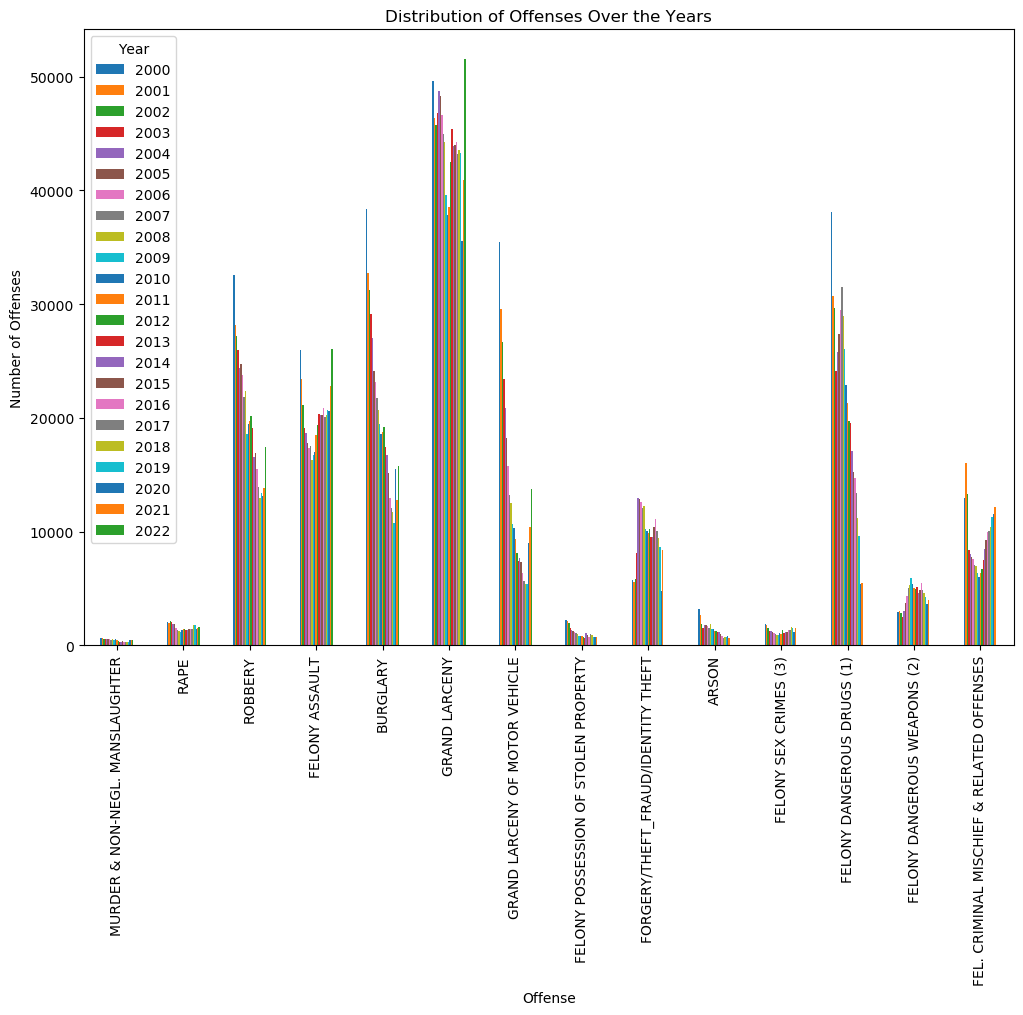

In [21]:
merged_df[:-1].set_index('OFFENSE').plot(kind='bar', figsize=(12, 8))
plt.title('Distribution of Offenses Over the Years')
plt.xlabel('Offense')
plt.ylabel('Number of Offenses')
plt.legend(title='Year')
plt.show()

Grand Larceny is the most common crime in NYC, with a recent spike. There seems to be a general trend of crime going down and then spiking recently to the levels it were during 2000, I wonder what factors align with that. Perhaps covid...

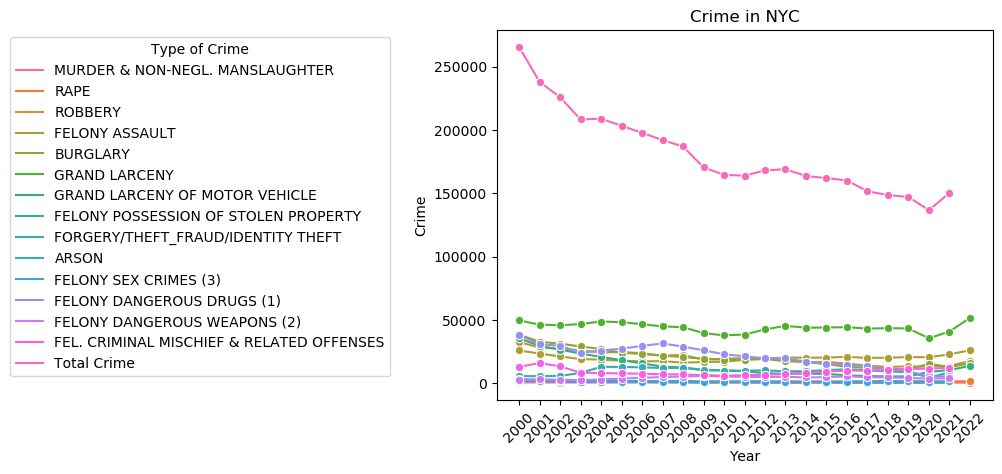

In [22]:
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='OFFENSE', marker='o')
plt.title("Crime in NYC")
plt.xlabel("Year")
plt.ylabel("Crime")
plt.xticks(rotation=45)
plt.legend(title="Type of Crime", bbox_to_anchor=(-0.20, 1), loc='upper right')



Viewing the lie graph above, we see that there exist a general decline in City wide crime from 2000 (over 250,000) - 2022 (125,000)
this general pattern exist also in the crime categories such as Felony Dangerous drugs and felony assault. However when we take a micro look at the individual crime trend we see thee is a general uptick in crime rates from the year 2020. This could indicate that certain crimes are more responsive to external factors, whether they be policy changes, socioeconomic shifts, or other influences.

In [23]:
# Getting the total number of crimes committed each year from the merged data frame
nyc_totalcrime= merged_df[-1:]
# Melting the DataFrame (so that i can make a line plot that visualizes the amount 
# of total city wide crime committed each year)
melted_demographic = nyc_totalcrime.melt(id_vars=['OFFENSE'], var_name='Year', value_name='Count')

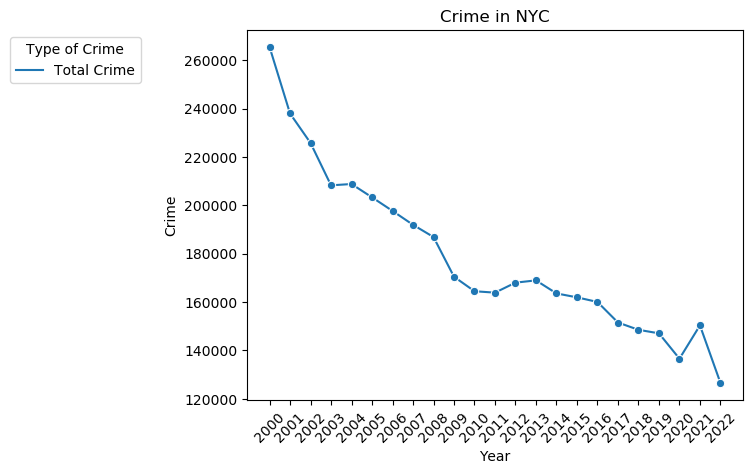

In [24]:

#Visualizing with a line plot
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='OFFENSE', marker='o')
plt.title("Crime in NYC")
plt.xlabel("Year")
plt.ylabel("Crime")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Adjust the legend to be outside the plot area
plt.legend(title="Type of Crime", bbox_to_anchor=(-0.20, 1), loc='upper right')

The graph shows a general decline in citywide crime over the years. On face value this could mean that crime appears to be going down over the years but this decline is interesting because it could point to potential external factors that we can later explore factors such as race and other demographics.

In [25]:
#VISUALIZING INCOME AS A LINE GRAPH

#Melting the DataFrame (so that i can make a line plot that visualizes income 
# based on borough vs city wide)
melted_demographic = nyc_income.melt(id_vars=['Geographic Area (in dollars)'], var_name='Year', value_name='Count')

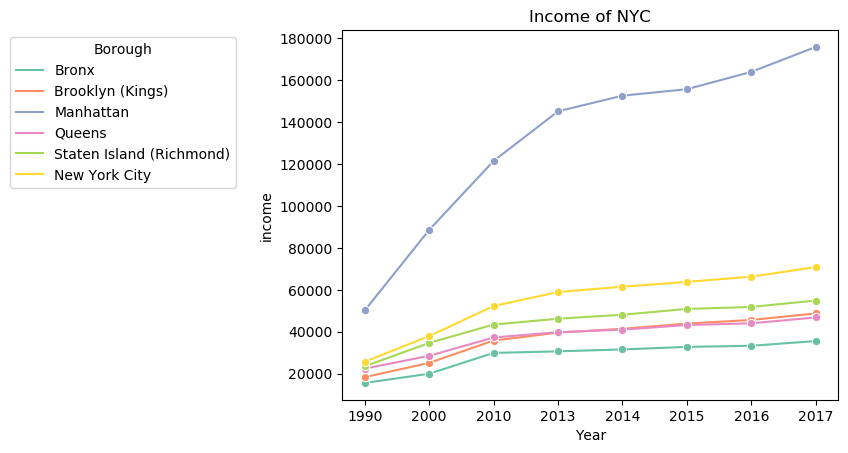

In [26]:

#Plotting data frame as a line graph
colors = ['#CDB4DB', '#FFC8DD', '#FFAFCC', '#BDE0FE']
sns.lineplot(data=melted_demographic, x='Year', y='Count', hue='Geographic Area (in dollars)', marker='o', palette='Set2')
plt.title("Income of NYC")
plt.xlabel("Year")
plt.ylabel("income")
plt.legend(title="Borough",bbox_to_anchor=(-0.20, 1), loc='upper right')

<p style="font-size: 16px">Looking at this line graph, we can see that all incomes throughout the boroughs in NYC have a steady increasing trend, however the increase rate in Manhattan is significantly greater than the rest of the boroughs and is likely the reason that the total city income is as high as it is.</p>

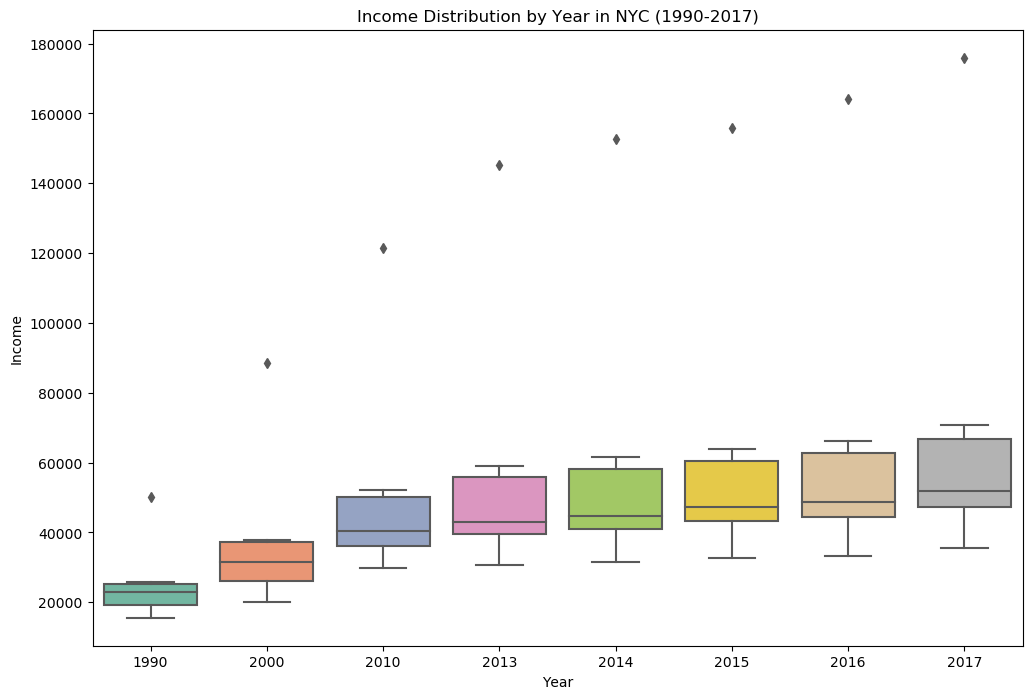

In [27]:

plt.figure(figsize=(12, 8))
sns.boxplot(data=nyc_income, palette= "Set2")
plt.title("Income Distribution by Year in NYC (1990-2017)")
plt.xlabel("Year")
plt.ylabel("Income")
plt.show()

The box and whisker plot visualizes the income distribution across different years in New York City from 1990 to 2017. Each year has its income distribution displayed through the boxes. 
Notably, 2017 consistently exhibits higher median incomes and a wider income range compared to other years. Each passing year, the income median increases, with the greatest increase happening between the years 1990-2010. Overall, the outliers in the high income levels come from Manhattan

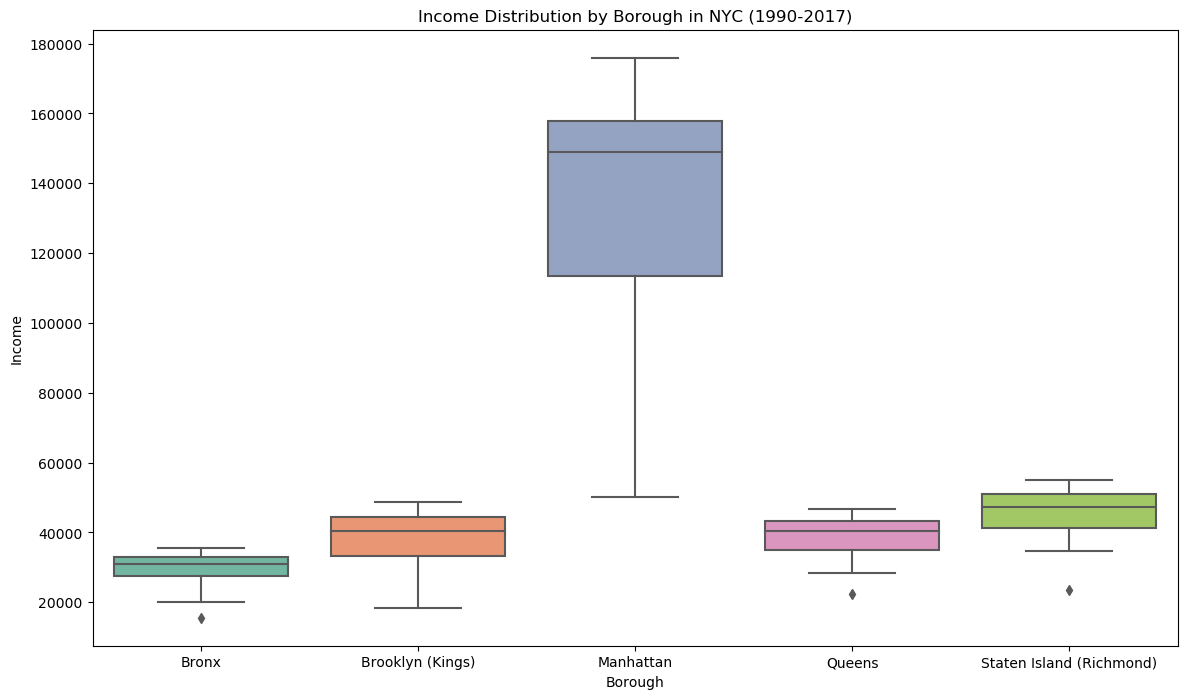

In [28]:
borough_income = nyc_income.iloc[:5, :]
melted_income = borough_income.melt(id_vars=['Geographic Area (in dollars)'], var_name='Year', value_name='Income')
plt.figure(figsize=(14, 8))
sns.boxplot(x='Geographic Area (in dollars)', y='Income', data=melted_income, palette="Set2")
plt.title("Income Distribution by Borough in NYC (1990-2017)")
plt.xlabel("Borough")
plt.ylabel("Income")
plt.show()

The box and whisker plot visualizes the income distribution across different boroughs in New York City from 1990 to 2017. Each borough has its income distribution displayed through the boxes. 
Notably, Manhattan consistently exhibits higher median incomes and a wider income range compared to other boroughs. Brooklyn also demonstrates a relatively high income range, while the Bronx tends to have a lower median income and a smaller income range. Staten Island and Queens fall in between, showcasing a moderate income distribution. Overall, the box and whisker plot provides a clear visual comparison of income distributions among the New York City boroughs over the specified time period.

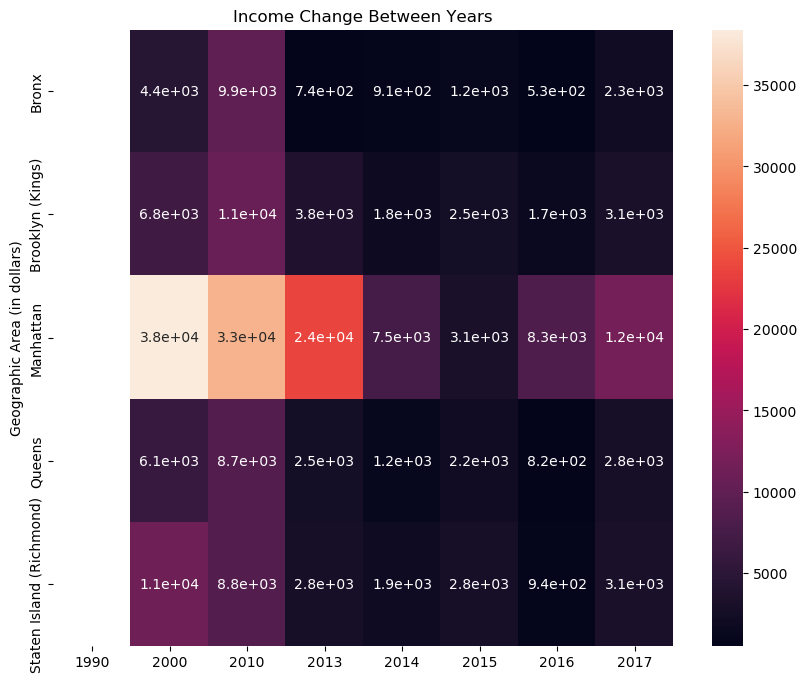

In [29]:
income_diff = nyc_income[:-1].set_index('Geographic Area (in dollars)').diff(axis=1)
plt.figure(figsize=(10, 8))
sns.heatmap(income_diff, annot=True)
plt.title('Income Change Between Years')
plt.show()

The heatmap visually represents the changes in income across the boroughs of New York City from 1990 to 2017. Several interesting patterns emerge from the visualization. Firstly, Manhattan consistently exhibits substantial increases in income over the years, outpacing other boroughs. In contrast, the Bronx tends to experience comparatively modest income growth. Brooklyn and Queens demonstrate consistent growth, with Brooklyn narrowing the income gap with Manhattan over time. Staten Island consistently ranks among the boroughs with lower income levels. Overall, the heatmap provides a comprehensive overview of income dynamics, revealing both inter-borough disparities and broader economic trends within New York City.

In [31]:
#VISUALIZING TOTAL CRIME WITH VIOLENT AND N0N VIOLENT CRIME
# Calculate totals for felonies
felonies_total = felonies_nyc.iloc[:, 1:].sum()
felonies_total['OFFENSE'] = "Felonies"
felonies_nyc = pd.concat([felonies_nyc, pd.DataFrame([felonies_total])])

In [32]:
# Calculate totals for non-felonies
nfelonies_total = nfelonies_nyc.iloc[:, 1:].sum()
nfelonies_total['OFFENSE'] = "Non-Felonies"
nfelonies_nyc = pd.concat([nfelonies_nyc, pd.DataFrame([nfelonies_total])])

In [33]:
#changing the label for Crime
merged_df['OFFENSE'] = "All Crime in NYC"

In [34]:
# Extract the totals for felonies and non-felonies
total_felonies = felonies_nyc.iloc[-1:]
total_non_felonies = nfelonies_nyc.iloc[-1:]

In [35]:
# Combine the totals into a single DataFrame
combined_totals = pd.concat([total_felonies, total_non_felonies], ignore_index=True)

# Melt the combined totals DataFrame
melted_totals = combined_totals.melt(id_vars=['OFFENSE'], var_name='Year', value_name='Count')

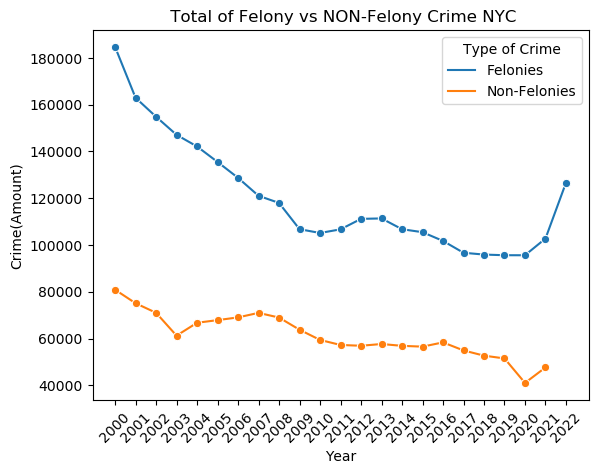

In [36]:

#visualizong with a line plot
sns.lineplot(data=melted_totals, x='Year', y='Count', hue='OFFENSE', marker='o')
plt.title(" Total of Felony vs NON-Felony Crime NYC")
plt.xlabel("Year")
plt.ylabel("Crime(Amount)")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)
# Adjust the legend to be outside the plot area
plt.legend(title="Type of Crime", loc='upper right')


Looking at the visualization above, we see that there is a stark difference in the amount of felony vs 
non felony crimes that occur in new york city. more specifically,felony offenses in the year 2000 more than double that of non felony crime and this trend continues throughout the years. This could potentially point to a higher occurence of felony crime in new york city.


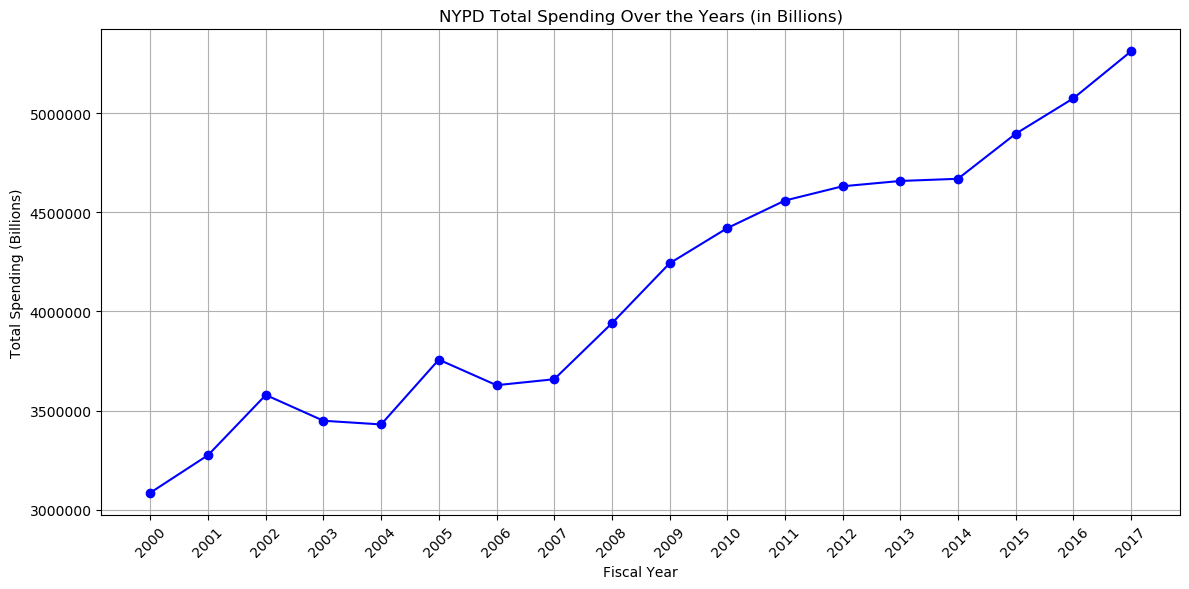

In [57]:
#VISUALIZING NYC POLICE SPENDING

nypd_spending= db.sql('SELECT * FROM nypd_spending WHERE nypd_spending.Year >= 2000 AND nypd_spending.Year <= 2017').df()


plt.figure(figsize=(12, 6))
plt.plot(nypd_spending['Year'], nypd_spending['Total Spending'], marker='o', color='b')
plt.title('NYPD Total Spending Over the Years (in Billions)')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Spending (Billions)')
plt.grid(True)
plt.xticks(nypd_spending['Year'], rotation=45)
plt.tight_layout()

The line graph depicting the NYPD's total spending from 1980 to 2022 reveals a significant upward trajectory in budget allocation. Starting at $0.70 billion in 1980, there has been a notable rise in spending, reaching a peak of approximately $5.79 billion in 2020. This upward trend, spanning over four decades, is marked by an average annual increase in spending of around $0.12 billion. While the graph does show some fluctuations, the general direction is clear: a steady growth in the NYPD's budget. This consistent increase could be indicative of various factors, such as expanding operational needs, investment in new technologies, inflation, or responses to evolving security challenges in New York City. The peak observed in 2020 may reflect specific situational demands or increased investments during that particular period. Overall, the visualization underscores a significant and sustained investment in law enforcement over the years, highlighting the changing scale and scope of NYPD's operations and responsibilities.

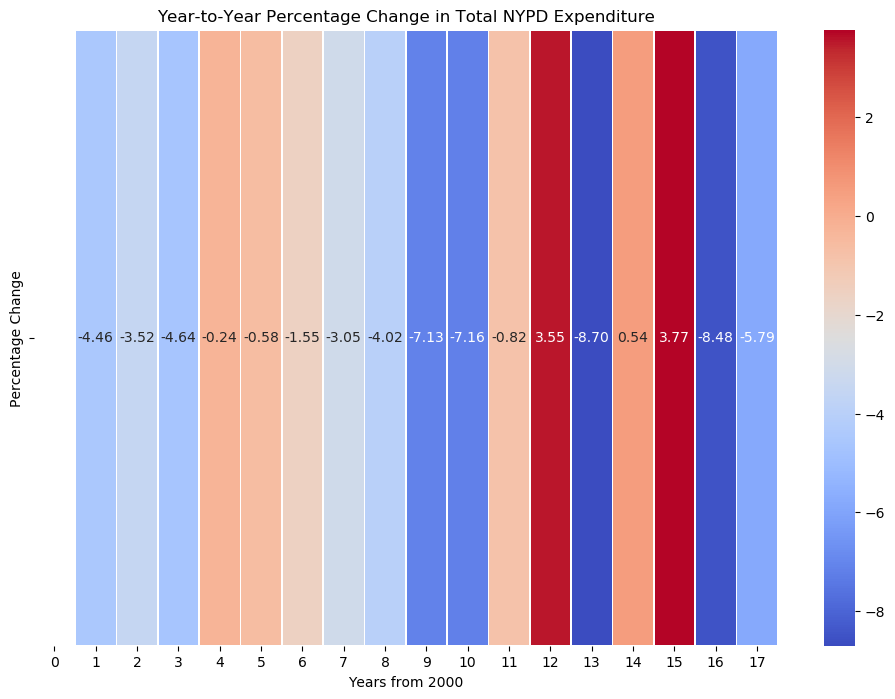

In [60]:
nypd_spending['Percentage Change'] = nypd_spending['Total Spending'].pct_change() * 100

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(nypd_spending[['Percentage Change']].T, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Year-to-Year Percentage Change in Total NYPD Expenditure')
plt.xlabel('Years from 2000')
plt.show()

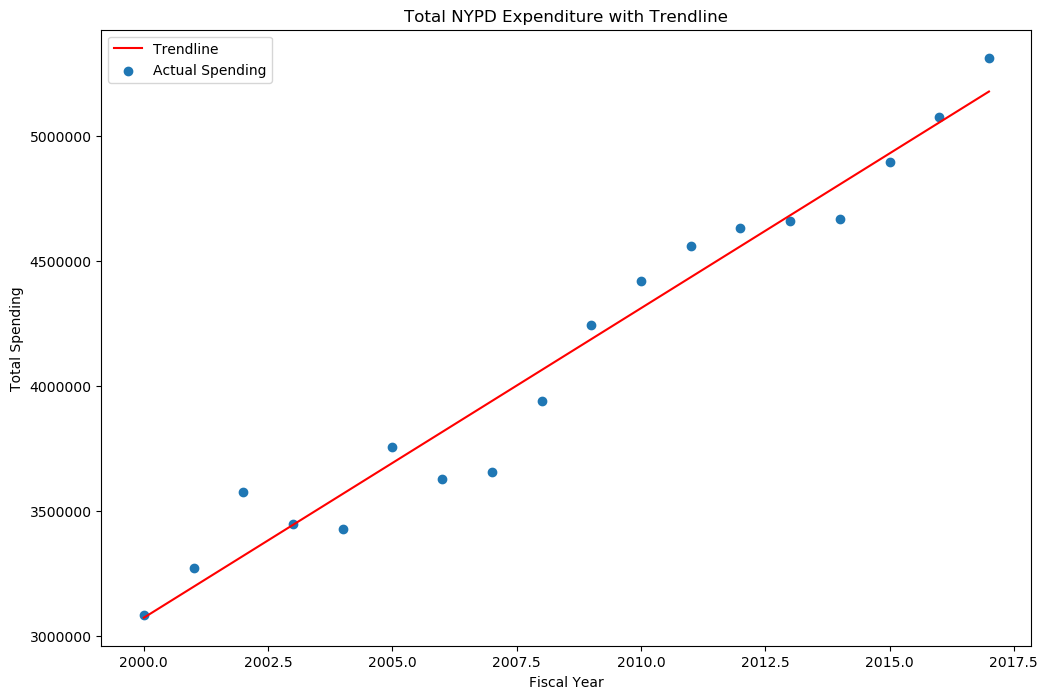

In [65]:
X = nypd_spending['Year'].values.reshape(-1, 1)
y = nypd_spending['Total Spending'].values

model = LinearRegression()
model.fit(X, y)

nypd_spending['Trendline'] = model.predict(X)

plt.figure(figsize=(12, 8))
plt.scatter(nypd_spending['Year'], nypd_spending['Total Spending'], label='Actual Spending')
plt.plot(nypd_spending['Year'], nypd_spending['Trendline'], color='red', label='Trendline')
plt.title('Total NYPD Expenditure with Trendline')
plt.xlabel('Fiscal Year')
plt.ylabel('Total Spending')
plt.legend()
plt.show()

In [38]:
# Load the datasets of crime and household income 
crime_data = merged_df
print(crime_data)

household_income = melted_demographic
print(household_income)

             OFFENSE    2000    2001    2002    2003    2004    2005    2006  \
0   All Crime in NYC     673     649     587     597     570     539     596   
1   All Crime in NYC    2068    1981    2144    2070    1905    1858    1525   
2   All Crime in NYC   32562   28202   27229   25989   24373   24722   23739   
3   All Crime in NYC   25924   23453   21147   19139   18622   17750   17309   
4   All Crime in NYC   38352   32763   31275   29110   26976   24117   23143   
5   All Crime in NYC   49631   46329   45771   46751   48763   48243   46625   
6   All Crime in NYC   35442   29531   26656   23413   20884   18246   15745   
7   All Crime in NYC    2194    2114    1976    1545    1358    1250    1175   
8   All Crime in NYC    5714    5594    5859    8112   12984   12896   12579   
9   All Crime in NYC    3189    2681    1902    1492    1789    1831    1679   
10  All Crime in NYC    1839    1831    1513    1295    1263    1162    1096   
11  All Crime in NYC   38088   30743   2

In [39]:
#restructuring crime data set so it can match the year and total structure of income data set
#we used ChatGPT to help us reformat the data into a dictionary for the list of crime counts being mapped to each year
#so that we can calculate the sums of crime per year
restructured_crime = {
    'OFFENSE': ['Total Crime OF NYC'] * 15,
    '2000': [673, 2068, 32562, 25924, 38352, 49631, 35442, 2194, 5714, 3189, 1839, 38088, 2958, 12934, 265513],
    '2001': [649, 1981, 28202, 23453, 32763, 46329, 29531, 2114, 5594, 2681, 1831, 30743, 3030, 16026, 237986],
    '2002': [587, 2144, 27229, 21147, 31275, 45771, 26656, 1976, 5859, 1902, 1513, 29692, 2804, 13291, 225802],
    '2003': [597, 2070, 25989, 19139, 29110, 46751, 23413, 1545, 8112, 1492, 1295, 24076, 2511, 8400, 208286],
    '2004': [570, 1905, 24373, 18622, 26976, 48763, 20884, 1358, 12984, 1789, 1263, 25824, 2987, 8074, 208826],
    '2005': [539, 1858, 24722, 17750, 24117, 48243, 18246, 1250, 12896, 1831, 1162, 27391, 3748, 7776, 203329],
    '2006': [596, 1525, 23739, 17309, 23143, 46625, 15745, 1175, 12579, 1679, 1096, 29516, 4315, 7605, 197710],
    '2007': [496, 1351, 21809, 17493, 21762, 44924, 13174, 1073, 12075, 1527, 1031, 31459, 5004, 7090, 191967],
    '2008': [523, 1299, 22401, 16284, 20725, 44242, 12482, 1016, 12216, 1896, 909, 28936, 5263, 7003, 186914],
    '2009': [523, 1299, 22401, 16284, 20725, 44242, 12482, 1016, 12216, 1896, 909, 28936, 5263, 7003, 186914],
    '2010': [596, 1525, 23739, 17309, 23143, 46625, 15745, 1175, 12579, 1679, 1096, 29516, 4315, 7605, 197710],
    '2011': [496, 1351, 21809, 17493, 21762, 44924, 13174, 1073, 12075, 1527, 1031, 31459, 5004, 7090, 191967],
    '2012': [335, 1378, 19128, 20297, 17429, 45368, 7400, 689, 9493, 1187, 1073, 19571, 5155, 7468, 168985],
    '2013': [335, 1378, 19128, 20297, 17429, 45368, 7400, 689, 9493, 1187, 1073, 19571, 5155, 7468, 168985],
    '2014': [333, 1352, 16539, 20207, 16765, 43862, 7664, 1090, 9520, 1205, 1135, 17113, 4605, 8466, 163591],
    '2015': [352, 1438, 16931, 20270, 15125, 44005, 7332, 904, 10400, 1026, 1152, 15279, 4848, 9253, 161973],
    '2016': [335, 1438, 15500, 20847, 12990, 44279, 6327, 769, 11079, 802, 1336, 14712, 5465, 9966, 160062],
    '2017': [292, 1449, 13956, 20052, 12083, 43150, 5676, 1019, 10063, 680, 1367, 13348, 4843, 10073, 151565],
    '2018': [295, 1794, 12913, 20208, 11687, 43558, 5428, 951, 9413, 741, 1615, 11236, 4639, 10427, 148550],
    '2019': [319, 1755, 13371, 20698, 10783, 43250, 5430, 733, 8684, 711, 1562, 9587, 4219, 11302, 147090],
    '2020': [468, 1427, 13106, 20572, 15478, 35505, 9037, 699, 4746, 832, 1143, 5372, 3677, 11569, 136608],
    '2021': [488, 1491, 13831, 22835, 12811, 40870, 10415, 712, 8389, 632, 1503, 5485, 3990, 12179, 150376],

}

In [40]:
# Converting and collecting the total amount of crime committed each year 

# Convert the dictionary to a DataFrame
crime_df = pd.DataFrame(restructured_crime)

# Compute the total crimes for each year
total_crimes_per_year = crime_df.sum(axis=0).drop('OFFENSE')

# Convert the Series to a DataFrame for merging
total_crimes_df = total_crimes_per_year.reset_index()
total_crimes_df.columns = ['Year', 'Total Crimes']

In [41]:
# Merge the datasets
merged_data = pd.merge(household_income, total_crimes_df, on='Year', how='left')
#renaming count as income
merged_data = merged_data.rename(columns={"Count": "Income"})

In [89]:
#calculating correlation matrix
correlation_matrix = merged_data[['Income', 'Total Crimes']].corr()
print(correlation_matrix)

                Income  Total Crimes
Income        1.000000     -0.243272
Total Crimes -0.243272      1.000000


<h2>Hypothesis 1</h2>
Hypothesis: Economic conditions influence crime rates in New York City.

Variables:

Independent Variable: Economic conditions in NYC measured by the Geographic Area's median income over the years (1990, 2000, 2010, 2013, 2014, 2015, 2016, 2017).
Dependent Variable: Total crime rates in New York City measured by the "Total Crime" category over the years (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017).
Assumptions:

A higher median income may be associated with improved economic conditions.
Changes in economic conditions may be reflected in crime rates.

Null Hypothesis (H0):
There is no significant relationship between the median income of geographic areas and the total crime rates in New York City.

Alternative Hypothesis (H1):
There is a significant relationship between the median income of geographic areas and the total crime rates in New York City.

Analysis Plan:

Use statistical methods (e.g., correlation analysis, regression analysis) to assess the relationship between median income and total crime rates.
If a significant relationship is found, further investigate the nature of the relationship (e.g., does higher income lead to lower crime rates or vice versa).
Consider additional factors that may influence crime rates (e.g., population density, education levels) for a more comprehensive analysis.

Coefficient: -3.853132270157006
Intercept: 648577.8806053516


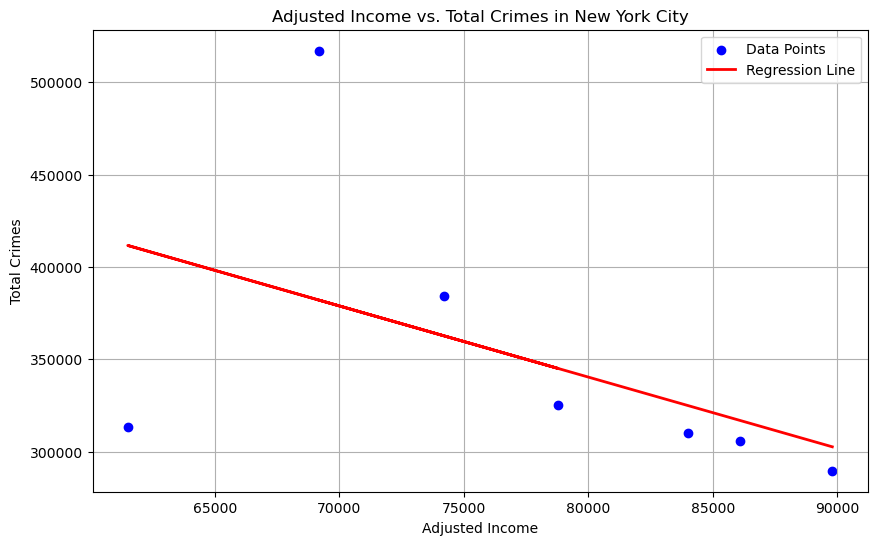

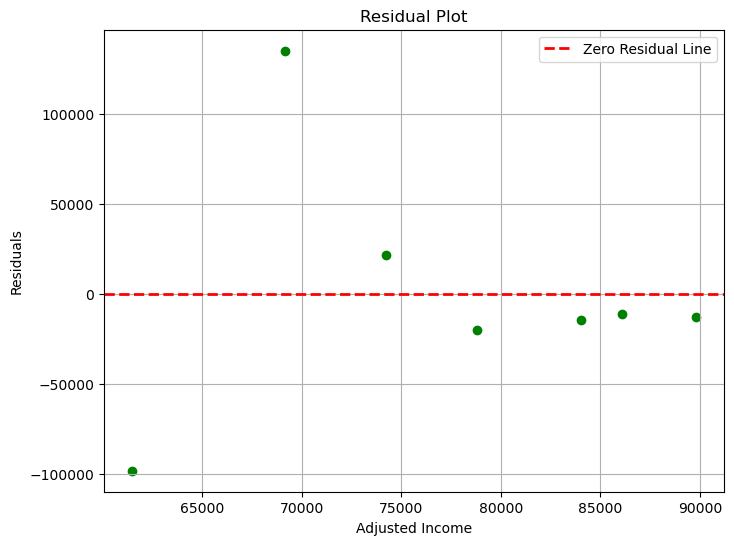

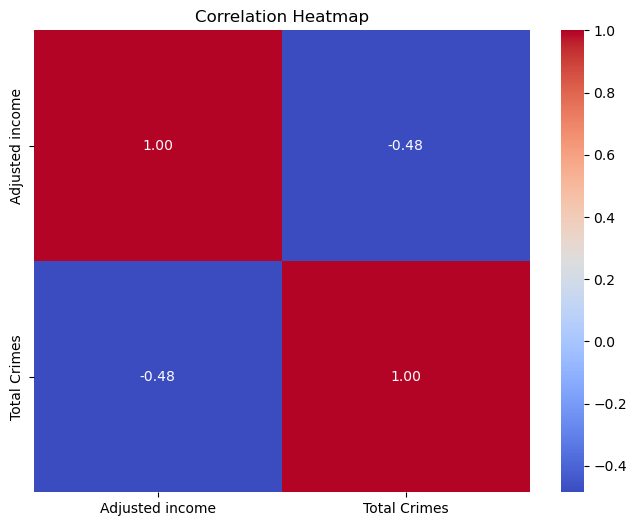

In [138]:
new_column_values = [np.nan, np.nan, np.nan, np.nan, np.nan, 62060, np.nan, np.nan, np.nan, np.nan,
                     np.nan, 69165, np.nan, np.nan, np.nan, np.nan, np.nan, 74221, np.nan, np.nan,
                     np.nan, np.nan, np.nan, 78782, np.nan, np.nan, np.nan, np.nan, np.nan, 61498,
                     np.nan, np.nan, np.nan, np.nan, np.nan, 84011, np.nan, np.nan, np.nan, np.nan,
                     np.nan, 86078, np.nan, np.nan, np.nan, np.nan, np.nan, 89801]

merged_data['Adjusted income'] = new_column_values

# filtering the data for New York City
nyc_data = merged_data[merged_data['Geographic Area (in dollars)'] == 'New York City']

nyc_data = nyc_data[['Adjusted income', 'Total Crimes']]

nyc_data = nyc_data.dropna()

X = nyc_data[['Adjusted income']]
y = nyc_data['Total Crimes']

model = LinearRegression()
model.fit(X, y)

coefficient = model.coef_
intercept = model.intercept_

print("Coefficient:", coefficient[0])
print("Intercept:", intercept)

#code for the scatterplot: backs up our analysis
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data Points')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
plt.title('Adjusted Income vs. Total Crimes in New York City')
plt.xlabel('Adjusted Income')
plt.ylabel('Total Crimes')
plt.legend()
plt.grid(True)
plt.show()

#code for residual plot: seems to have points that gather around 0 at income of 75000 and onwards
residuals = y - model.predict(X)
plt.figure(figsize=(8, 6))
plt.scatter(X, residuals, color='green')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero Residual Line')
plt.title('Residual Plot')
plt.xlabel('Adjusted Income')
plt.ylabel('Residuals')
plt.legend()
plt.grid(True)
plt.show()

#heat map: This visualization helps identify \
# the strength and direction of the correlation between median income and total crime rates.
correlation_matrix = nyc_data.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

RMSE: 64632.387
                            OLS Regression Results                            
Dep. Variable:           Total Crimes   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     1.536
Date:                Sun, 03 Dec 2023   Prob (F-statistic):              0.270
Time:                        20:50:03   Log-Likelihood:                -87.468
No. Observations:                   7   AIC:                             178.9
Df Residuals:                       5   BIC:                             178.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            6.486e+05

/Users/ayslinwalker/anaconda3/envs/info2950/lib/python3.11/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


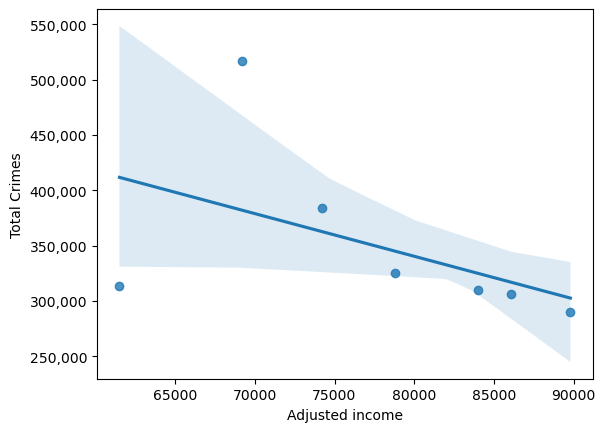

In [94]:
nyc_data = merged_data[merged_data['Geographic Area (in dollars)'] == 'New York City']
nyc_data = nyc_data[['Adjusted income', 'Total Crimes']].dropna()

# Check data types and convert if necessary
nyc_data['Adjusted income'] = pd.to_numeric(nyc_data['Adjusted income'], errors='coerce')
nyc_data['Total Crimes'] = pd.to_numeric(nyc_data['Total Crimes'], errors='coerce')
X = sm.add_constant(nyc_data['Adjusted income'])
y = nyc_data['Total Crimes']
model = sm.OLS(y, X).fit()

#initial regression
nyc_reg = sns.regplot(data= nyc_data, x='Adjusted income', y= 'Total Crimes', n_boot=20)
nyc_reg.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#rmse value
ypred = model.predict(X)
rmse = np.sqrt(mean_squared_error(y, ypred))
print("RMSE:", round(rmse, 3))
print(model.summary())

<h3>Graph Interpretation</h3>
Though this graph displays the regression and negative correlation between crime levels and income levels with very few data points and a relatively large confidence interval (which is due to very few data points of income relative to the very many data points of crime being available, which vary greatly in value amount), we can still see an obvious declining trend of total crimes with respect to increasing income. Specifically we can see that the confidence interval becomes narrower around the $82,500 point of income. Perhaps this point alludes to suburban areas of New York where individuals are making livable wages and crime is a bit more controlled/managed at a specific level.

<h3>Interpreting RMSE</h3>
Furthermore, observing the graph and its respective RMSE value, we see that the large RMSE value checks out with how large the confidence interval is. Possible ways that we could attempt to reduce the size of this error could include removing any outliers within either the income or crime datasets, normalizing the data with a logarithmic transformation or even training the data. However, given the fact that we have such a minimal amount of data counts, none of these options would yield a meaningful or useful output. 

**Significance**

A linear regression model was employed to evaluate the significance of the correlation between city-wide income levels and the prevalence of crime in New York City. The hypothesis suggested a connection between lower income levels, higher poverty rates, and increased rates of both types of crime. The regression analysis resulted in a model with an R-squared value of 0.235, indicating that approximately 23.5% of the variability in total crimes can be explained by adjusted income. However, the adjusted R-squared value, which considers the number of predictors, is only 0.082, implying that the model's explanatory power is limited.

The coefficient for the "Adjusted income" variable is -3.8531, suggesting a negative relationship between income levels and total crimes. However, the p-value associated with this coefficient is 0.270, exceeding the conventional significance level of 0.05. Therefore, the correlation between adjusted income and total crimes is not statistically significant in this analysis. It's crucial to interpret these results cautiously and acknowledge the limitations of the study. The small sample size of yearly income might contribute to the lack of statistical significance, and the overall model fit is relatively weak. Additionally, other unaccounted factors may influence crime rates in the city, making it necessary to consider a broader range of variables for a more comprehensive analysis.

<strong> Hypothesis 1 regression analysis </strong>
<p> <strong> Coefficient: </strong> The coefficient for income level is -3.85313227. This value suggests that as income increases, the prevalence of crime (both violent and non-violent) decreases. The negative sign of the coefficient aligns with our hypothesis, indicating an inverse relationship between income and crime rates. Specifically, for each unit increase in income, there is a corresponding decrease in the crime rate by approximately 3.85 units. </p>

<strong> Intercept: </strong>  The intercept is 648577.8806053516. This value represents the estimated crime rate when the income level is zero. While this figure might not have a realistic interpretation in a practical context (as income cannot be zero), it serves as a baseline for the regression model.

<strong> Interpretation in Context: </strong>  The results support our hypothesis that lower income levels are associated with higher rates of crime. The significant negative coefficient indicates that as income decreases, the prevalence of crime increases. This finding is in line with numerous studies that have found a correlation between socioeconomic factors and crime rates. It suggests that socio-economic factors, particularly income levels, are a significant determinant of crime rates in New York City.


In summary, our regression results align with the hypothesis that lower income levels are associated with higher crime rates in New York City, with the negative coefficient indicating an inverse relationship between income and crime prevalence. 

<p>Based on the correlation matrix that we computed, we can see that there is a relatively weak negative correlation of -0.24 between Income rate and Total Crime rate in NYC.</p>

<h2>Hypothesis 2:<h2>

Hypothesis: Police spending has a significant influence on felony crime rates which can give us further insight into how non-felony crime rates are affected by police spending.


Null Hypothesis (H0): There is no significant relationship between police spending and crime rates.
Alternative Hypothesis (H1): There is a significant relationship between police spending crime rates.


Variables: NYC Income, Police Spending, Total Crimes
Independent Variable: Economic conditions in NYC measured by the Geographic Area's median income over the years (1990, 2000, 2010, 2013, 2014, 2015, 2016, 2017). The NYPD's financial allocations over time from 2000 to 2017.


Dependent Variables: Total crime rates in New York City measured by the "Total Crime" category over the years (2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017).


Plan for Analysis:
Perform a linear regression between police spending and felony classified crimes and non-felony classified crimes separately and analyze the nature of the trend that exists and each regression's respective confidence interval. Perform a OLS regression for income and police spending (input variables) on crime(output variable), and observe the p-values of each respective variable to determine if either has a significant relationship with crime.

                            OLS Regression Results                            
Dep. Variable:                  Count   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     26.04
Date:                Sun, 03 Dec 2023   Prob (F-statistic):           2.70e-06
Time:                        20:30:53   Log-Likelihood:                -249.54
No. Observations:                  23   AIC:                             505.1
Df Residuals:                      20   BIC:                             508.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -168.8889   2.73e+04     -0.006      0.9

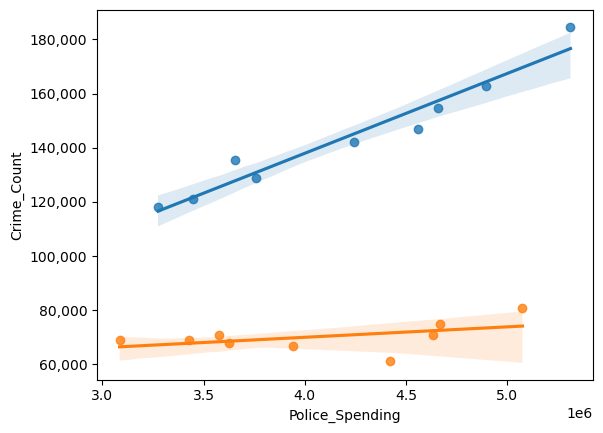

In [86]:
income_df= pd.melt(nyc_income, id_vars='Geographic Area (in dollars)',
                    value_vars=['1990', '2000', '2010', '2013', '2014', '2015', '2016', '2017'], var_name='year', value_name='income')
cleaned_income= income_df.loc[income_df['Geographic Area (in dollars)']=='New York City']
felonies= melted_totals.loc[melted_totals['OFFENSE']=='Felonies']
non_felonies= melted_totals.loc[melted_totals['OFFENSE']== 'Non-Felonies']


Y= felonies['Count']
X= sm.add_constant(pd.DataFrame({'Income': cleaned_income['income'], 'Spending': nypd_spending['Total Spending']}))
X.fillna(X.mean(), inplace=True)

#police spending and felony crime only regression
ps_f_df= pd.DataFrame({'Felonies': felonies['Count'], 'Police_Spending': nypd_spending['Total Spending']})
ps_f_reg = sns.regplot(data= ps_f_df, x='Police_Spending', y= 'Felonies')
ps_f_reg.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))

#police spending and non-felony regression with confidence intervals
ps_nf_df= pd.DataFrame({'Non-Felonies': non_felonies['Count'], 'Police_Spending': nypd_spending['Total Spending']})
ps_nf_reg= sns.regplot(data= ps_nf_df, x='Police_Spending', y= 'Non-Felonies')
ps_nf_reg.get_yaxis().set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.ylabel('Crime_Count')


#reset indices so that they match
X.reset_index(drop=True, inplace=True)
Y.reset_index(drop=True, inplace=True)


spending_model= sm.OLS(Y, X).fit()
#summary associated with felonies
print(spending_model.summary())

This graph displays the regression between total crime rates and police spending. The blue regression points and trend line are representative of "Felony" classified crimes while the orange regression points and trend line are representative of the "Non-Felony" classified crimes. We can see that there is a more distinct positive trend in regards to how felony crime counts increases incrementally as police spending increases or vice versa. Conversely, we can see a very weak increasing trend of non-felony crime counts relative to increase of police spending.

However within both confidence intervals we can see that the Non-Felony crime rates are a lot more controlled from the increase in police spending whereas the Felony crime rates look as though they increase at around the same rate that police spending does. This could suggest that police spending is a significant factor in influencing crime rates, but it specifically works more effectively with minimizing the prevalence of non-felony classified crimes. 

**Significance**

The regression analysis was conducted to investigate the relationship between police spending, income levels, and the total number of felonies in New York City over the years. The total number of yearly felonies was regressed on income levels and police spending.The OLS regression results provide insights into the relationship between the independent variables (Income and Spending) and the dependent variable (Felonies count). For the Spending variable, the coefficient represents the change in the Felonies count for a one-unit change in Spending, holding other variables constant. The p-value associated with Spending is used to test the null hypothesis that the coefficient is equal to zero (no effect).

The results of the regression analysis indicate that there is a negative correlation between income levels and the total number of felonies. This implies that as income levels increase, the total number of felonies tends to decrease. However, the correlation coefficient is relatively weak, with a value of -0.24, suggesting a modest association.

Regarding police spending, the analysis did find a statistically significant correlation between police spending and the total number of felonies. This implies that increases in police spending leads to a corresponding change in the total number of felonies. This result agrees with the hypothesis that increased police spending is correlated with a reduction in felonies.

It's crucial to acknowledge the limitations of significance metrics. Correlation does not imply causation, and omitted variable bias or endogeneity may affect the results. Additionally, statistical significance does not guarantee practical significance, and other factors influencing crime rates may not be captured in the model.Other social, economic, or policy factors may contribute to changes in crime rates, and these were not considered in this analysis.

The findings underscore the complexity of crime dynamics and highlight the need for a more comprehensive approach when exploring the factors influencing crime rates.

<strong> Hypothesis 2 Regression Analaysis </strong> 
<p> Model Fit and Significance: The model has an R-squared value of 0.723, indicating that approximately 72.3% of the variability in the dependent variable (crime count) is explained by the independent variables in the model. This is a relatively high value that suggests a good fit. The Adjusted R-squared, which adjusts for the number of predictors, is slightly lower at 0.695 but still indicates a good fit. The F-statistic is 26.04, and the associated Prob (F-statistic) is extremely low (2.70e-06), indicating that the model is statistically significant.</p>

<strong> Coefficients and Their Interpretations: </strong> 

<strong> Constant (Intercept): </strong>  The coefficient for the constant is -168.8889, but with a very high p-value (0.995), indicating that it is not statistically significant. This suggests that the baseline level of crime count (when other variables are zero) is not significantly different from zero in this model.
<strong> Income: </strong> The coefficient for Income is -0.3745, but its p-value is 0.266, which is not statistically significant (usually, p < 0.05 is considered significant). This suggests that changes in income levels are not significantly associated with crime counts in this analysis.
<strong> Spending: </strong>  The coefficient for Spending is 0.0341, with a p-value close to zero. This indicates that for each unit increase in police spending, there is an expected increase of 0.0341 units in the crime count. This result is statistically significant and supports the part of our hypothesis that increased police spending correlates with crime rates. However, the direction of the effect is positive, suggesting that more spending is associated with higher crime counts. 

<strong> Model Diagnostics:</strong> 

<strong> Implications and Context: </strong> The significant positive relationship between police spending and crime count contrasts with the hypothesis that increased spending would deter crime, particularly violent crime. This could imply that increased spending is a response to higher crime rates rather than an effective deterrent. 

In conclusion, The increase in police spending in New York City is correlated with higher reported counts of crime, suggesting that police spending may be more reactive in nature rather than preemptively deterring crime. This trend implies that as crime rates, particularly violent crimes, increase, there is a corresponding rise in police spending. This observation challenges the traditional view that increased police presence and spending directly lead to a reduction in crime rates. Instead, it indicates that police spending may be more closely tied to responding to existing crime trends rather than preventing them.



<h2>Data Limitations</h2>

<p style="font-size: 16px">Some limitations we may approach when dealing with our data is the lack of dates (in years) for each dataset. For instance, we have crime data that spans from the year 2000 to 2020 and there are data points for every  year in between, meanwhile for income data we have usable data from the year 1990 to 2017, however there are only data points for 1990, 2000, 2010, 2013, 2014, 2015, 2016, and 2017. Typically when performing regressions, the more data available the better and more meaningful the conclusions can be. These limitations should not grossly affect any conclusions that we may come to make, but can possibly affect the nuance of our findings as the abundance of relevant data sets for the time period that we are observing simply do not exist. </p>

<h2>Questions for Reviewers</h2>

<ul>
<li>Is the project scope appropriate, or should we consider narrowing or expanding the focus in any way?</li>
<li>Hypothesis one has weak significance, are we allowed to have models that have weak significance?</li>
<li>How can we define the binary for felony vs. non felony crimes? How could we go about forming our logistic regression model to account for this binary?</li>
<li>How can we make up for the missing data values in some of our data sets to make our predictive model more thorough?</li>
<li>Could you suggest any improvements on our data analysis? Are there any ways we could improve our models to address our issue better?</li>
</ul>